# Phase plane plot

# Purpose
Exploring the possibilities with *phase plane plots*

# Methodology
Quickly describe assumptions and processing steps.

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [9]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from scipy.integrate import solve_ivp

## Matplotlib example

Text(0.5, 1.0, 'Varying Density')

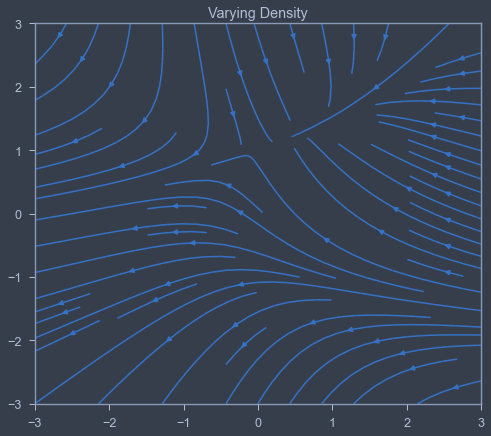

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig,ax=plt.subplots()
ax.streamplot(X, Y, U, V, density=[0.5, 1])
ax.set_title('Varying Density')

## Example from book
Logistic equation ($r=1$, $K=1$):
$$\dot{x} = x\cdot(1-x)$$

In [109]:
def logistic_equation(t,x):
    xd1 = x*(1-x)
    return xd1
        

In [110]:
dt = 0.5
t = np.arange(0,10,dt)
n_x = 15
x = np.linspace(0,2,n_x)

In [111]:
T = np.tile(t,(n_x,1))
T.shape

(15, 20)

In [112]:
X = np.tile(x,(len(t),1)).T
X.shape

(15, 20)

In [113]:
dT = dt*np.ones((n_x,len(t)))
dT.shape

(15, 20)

In [114]:
dXdT = logistic_equation(t=T,x=X)

In [142]:
x0s = [2,1,0.5,0.03,0.03]
t0s = [0,0,5,0,3]
xs = []
sims = OrderedDict()

for t0,x0 in zip(t0s,x0s):
    t_ = np.linspace(t0,t[-1],100)
    t_span = (t_[0],t_[-1])
    result = solve_ivp(fun = logistic_equation, t_span=t_span,  y0=[x0], t_eval=t_)
    
    sim = {
        't':t_,
        'x':result.y[0],
    }
    key = (t0,x0)
    sims[key]=sim
    

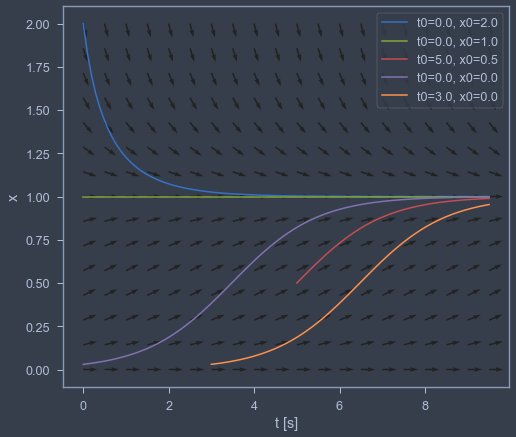

In [207]:
fig,ax=plt.subplots()

# Normalize the arrows:
lengths = np.sqrt(dT**2 + dXdT**2)
U = dT / lengths
V = dXdT / lengths

ax.quiver(T, X, U, V)

for key,sim in sims.items():
    label = 't0=%0.1f, x0=%0.1f' % key
    ax.plot(sim['t'],sim['x'], label=label)

ax.set_ylabel('x')
ax.set_xlabel('t [s]')
ax.legend();

In [203]:
def stream_plot(t, density=[0.5, 1], ax=None):

    n_x = 20
    x = np.linspace(0,2,n_x)
    T = np.tile(t,(n_x,1))
    X = np.tile(x,(len(t),1)).T
    dT = dt*np.ones((n_x,len(t)))
    dXdT = logistic_equation(t=T,x=X)
    
    if ax is None:
        fig,ax=plt.subplots()
    
    ax.streamplot(t, x, dT, dXdT, density=density)
    ax.set_xlabel('t [s]')
    return ax

In [ ]:
fig,ax=plt.subplots()
ax.streamplot(X, Y, U, V, density=[0.5, 1])

In [11]:
B_1_zeta_eq = sp.Eq(symbols.B_1, 2*symbols.zeta*symbols.omega0*symbols.A_44)
B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

In [12]:
eqs = [
    B_1_zeta_eq,    
    equations.analytical_solution,
      ]

analytical_solution_B_1 = sp.Eq(symbols.phi,
                                sp.simplify(sp.solve(eqs,symbols.zeta,symbols.phi)[0][1]))
analytical_solution_B_1

Eq(phi(t), (4*A_44**2*omega0**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) + 2*A_44**2*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2)*Derivative(phi_0(t), t) + A_44*B_1*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*phi_0(t)*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) - B_1**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2))*exp(-B_1*t/(2*A_44))/(4*A_44**2*omega0**2 - B_1**2))

In [13]:
analytical_lambda = lambdify(sp.solve(analytical_solution_B_1,symbols.phi)[0])

In [14]:
A_44=1 
B_1=0.1
omega0


phi_0, phi_01d

NameError: name 'omega0' is not defined

In [ ]:
analytical_lambda